## Install/ Import library

In [ ]:
# libraries
!pip install pymssql
import pymssql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import imblearn
from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance as plot_importance_xgb
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Data Connection & Understanding

In [ ]:
# Server: 45.117.83.230 - Port : 1433
# - Account : Student_DA_Q1 - Table: [dbo].[Customer_Churn_Banker]
# - Password: @MindXDream2023

server = '45.117.83.230'
port = 1433
account = 'Student_DA_Q1'
password = '@MindXDream2023'
db = 'DA_FINALTEST'

connection = pymssql.connect(host = server, port = port, user = account, password = password, database = db)
query = 'SELECT * FROM [dbo].[Customer_Churn_Banker]'

# Gán kết quả query vào dataframe
df = pd.read_sql(query, connection)

df

<ipython-input-2-ea0ab50b29cf>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.0,1,1,1,10134888.0,1
1,15647311,608,Spain,Female,41,1,8380786.0,1,0,1,11254258.0,0
2,15619304,502,France,Female,42,8,1596608.0,3,1,0,11393157.0,1
3,15701354,699,France,Female,39,1,0.0,2,0,0,9382663.0,0
4,15737888,850,Spain,Female,43,2,12551082.0,1,1,1,790841.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,France,Male,39,5,0.0,2,1,0,9627064.0,0
9996,15569892,516,France,Male,35,10,5736961.0,1,1,1,10169977.0,0
9997,15584532,709,France,Female,36,7,0.0,1,0,1,4208558.0,1
9998,15682355,772,Germany,Male,42,3,7507531.0,2,1,0,9288852.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


=> We can see that we have categorical and numeric variables

In [ ]:
df.shape

(10000, 12)

In [ ]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,6.980471e+06,1.530200,0.70550,0.515100,9.089385e+06,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,6.285896e+06,0.581654,0.45584,0.499797,6.128208e+06,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000e+00,1.000000,0.00000,0.000000,5.230000e+02,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000e+00,1.000000,0.00000,0.000000,3.336751e+06,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,8.668510e+06,1.000000,1.00000,1.000000,8.890572e+06,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,1.246215e+07,2.000000,1.00000,1.000000,1.439529e+07,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,2.508981e+07,4.000000,1.00000,1.000000,1.999925e+07,1.000000


In [ ]:
df.describe(exclude=['int64', 'float64'])

,country,gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


In [ ]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

# Data Preprocessing

###Data Cleaning

In [ ]:
# check missing data
df.isnull().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


=> See that we don't have null values

In [ ]:
df.duplicated().sum()

0

# EDA (Exploratory Data Analysis)

### Univariate

<ipython-input-10-8e6aaf6bbdc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'country', palette = 'Set2', data = df)
<ipython-input-10-8e6aaf6bbdc1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'gender', palette = 'Set2', data = df)
<ipython-input-10-8e6aaf6bbdc1>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'credit_card', palette = 'Set2', data = df)
<ipython-input-10-8e6aaf6bbdc1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variab

<Axes: title={'center': 'Variable Churn'}, xlabel='churn', ylabel='count'>

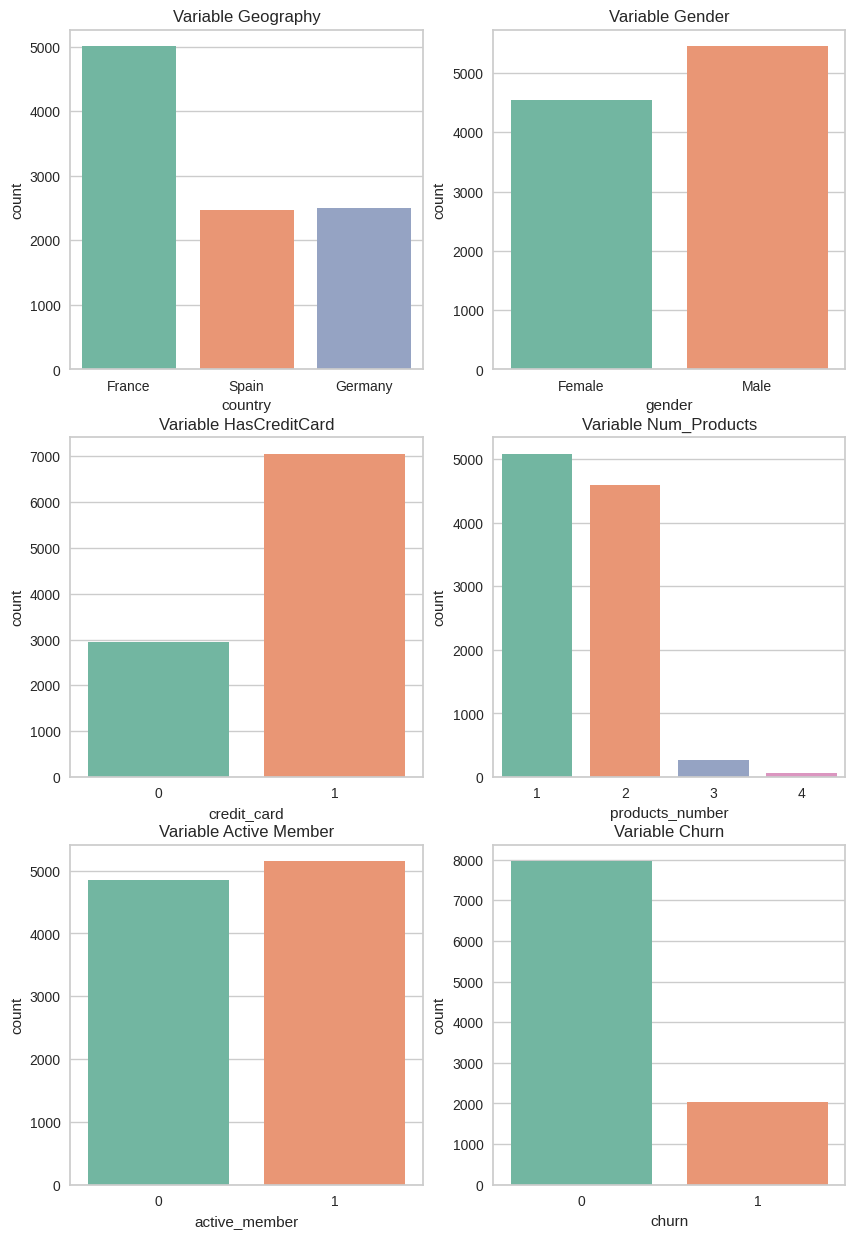

In [ ]:
plt.figure(figsize = (10,15))

plt.subplot(3, 2, 1)
plt.gca().set_title('Variable Geography')
sns.countplot(x = 'country', palette = 'Set2', data = df)

plt.subplot(3, 2, 2)
plt.gca().set_title('Variable Gender')
sns.countplot(x = 'gender', palette = 'Set2', data = df)

plt.subplot(3, 2, 3)
plt.gca().set_title('Variable HasCreditCard')
sns.countplot(x = 'credit_card', palette = 'Set2', data = df)

plt.subplot(3, 2, 4)
plt.gca().set_title('Variable Num_Products')
sns.countplot(x = 'products_number', palette = 'Set2', data = df)

plt.subplot(3, 2, 5)
plt.gca().set_title('Variable Active Member')
sns.countplot(x = 'active_member', palette = 'Set2', data = df)

plt.subplot(3, 2, 6)
plt.gca().set_title('Variable Churn')
sns.countplot(x = 'churn', palette = 'Set2', data = df)

* Ở biểu đồ 1, ta thấy rằng đa phần khách hàng đến từ France
* Ở biểu đồ 2, có sự phân phối khá đồng đều giữa khách hàng nam và nữ
* Ở biểu đồ 3, số khách hàng có thẻ tín dụng nhiều gấp đôi non-users
* Ở biểu đồ 4, khách hàng đa phần mua 1-2 products
* Ở biểu đồ 5, số khách hàng active and non-active gần như ngang nhau
* Ở biểu đồ 6, số khách hàng rời bỏ rất ít so với số người ở lại --> Not well distributed => cần balance khi đưa vào model



<Axes: xlabel='estimated_salary', ylabel='Count'>

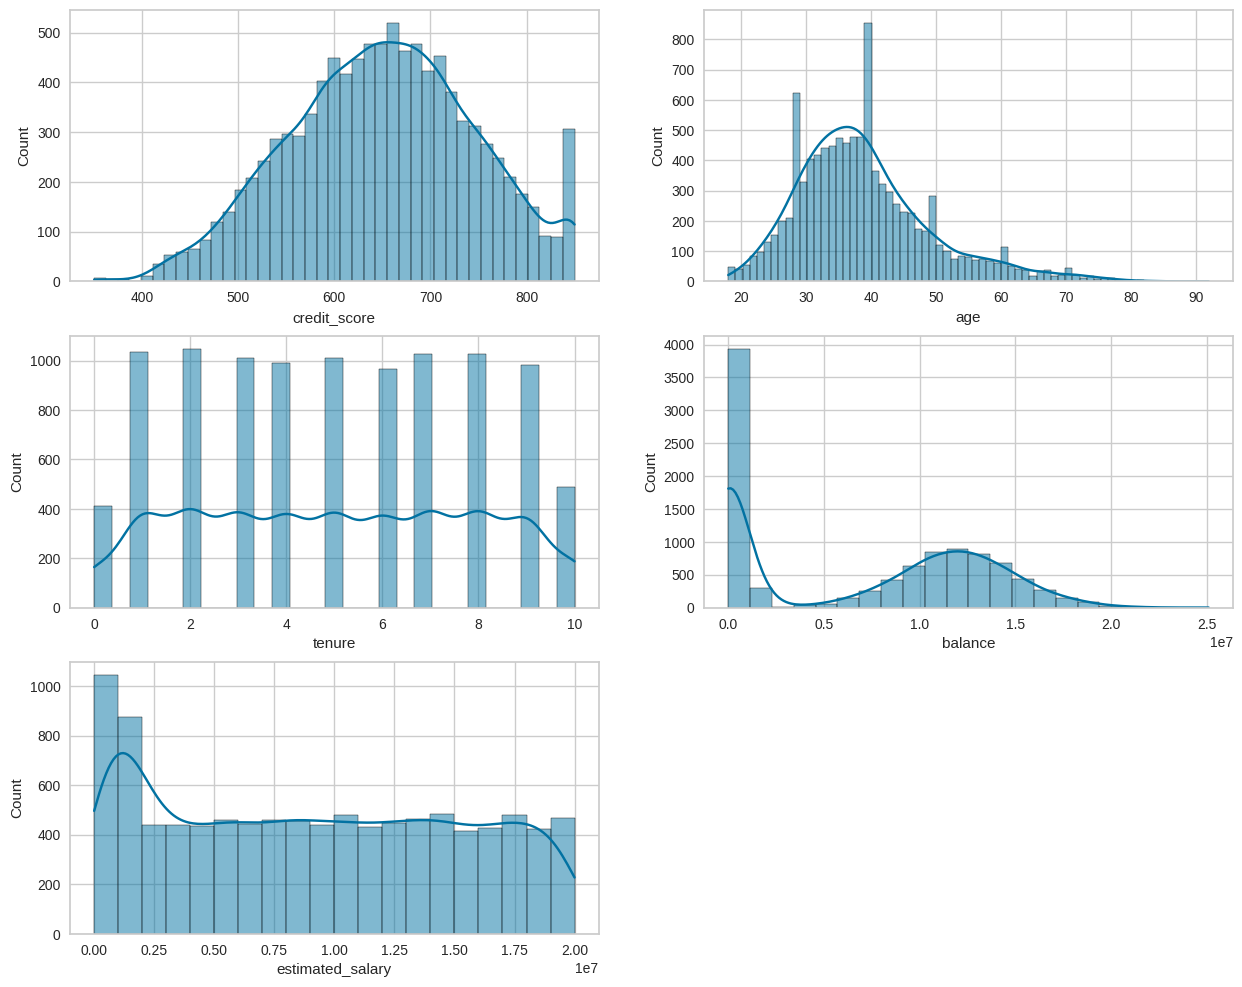

In [ ]:
plt.figure(figsize = (15, 12))

plt.subplot(3, 2, 1)
sns.histplot(x = df['credit_score'], kde = True)

plt.subplot(3, 2, 2)
sns.histplot(x = df['age'], kde = True)

plt.subplot(3, 2, 3)
sns.histplot(x = df['tenure'], kde = True)

plt.subplot(3, 2, 4)
sns.histplot(x = df['balance'], kde = True)

plt.subplot(3, 2, 5)
sns.histplot(x = df['estimated_salary'], kde = True)

* Biểu đồ 1,2: biến Credit_score và Age có sự phân phối chuẩn không hoàn hảo
* Biểu đồ 3: well - distributed
* Biểu đô 4: Hầu hết khách hàng đều là những người không có tiền trong tài khoản, trong khi những người có tiền thì phân bố khá đồng đều
* Biểu đồ 5: Số người trong mỗi khoảng thu nhập gần như là như nhau.

<Axes: title={'center': 'Boxplot CreditScore'}, xlabel='credit_score'>

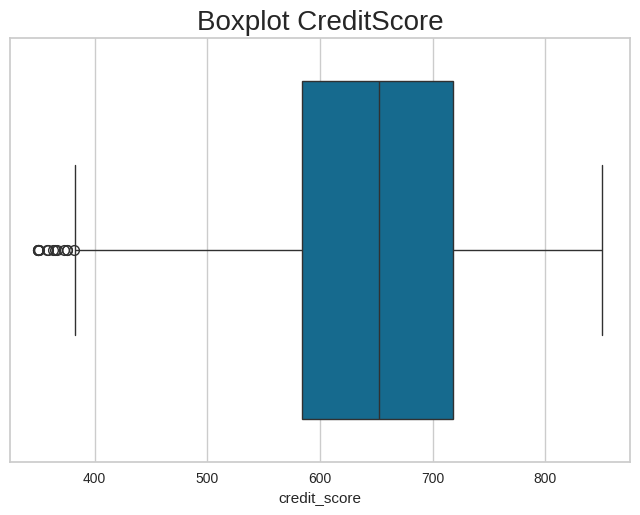

In [ ]:
plt.title("Boxplot CreditScore", fontdict = {'fontsize': 20})
sns.boxplot(x=df["credit_score"])

<Axes: title={'center': 'Boxplot Age'}, xlabel='age'>

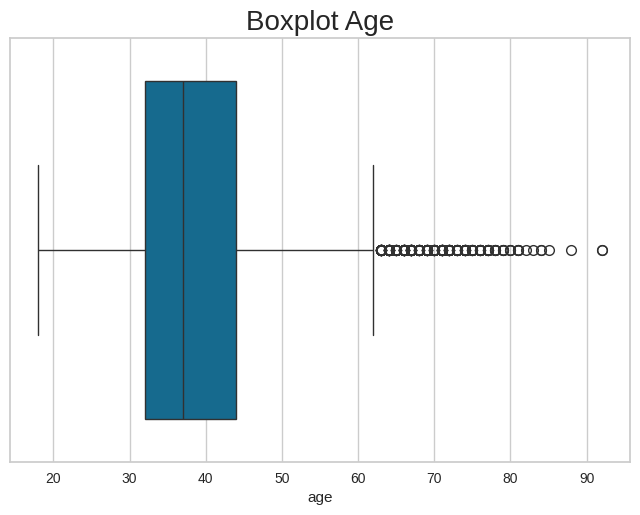

In [ ]:
plt.title("Boxplot Age", fontdict = {'fontsize': 20})
sns.boxplot(x=df["age"])

<Axes: title={'center': 'Boxplot Balance'}, xlabel='balance'>

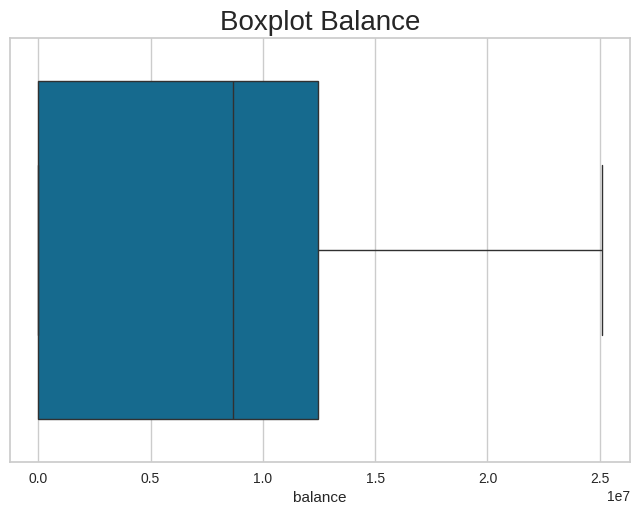

In [ ]:
plt.title("Boxplot Balance", fontdict = {'fontsize': 20})
sns.boxplot(x=df["balance"])

<Axes: title={'center': 'Boxplot EstimatedSalary'}, xlabel='estimated_salary'>

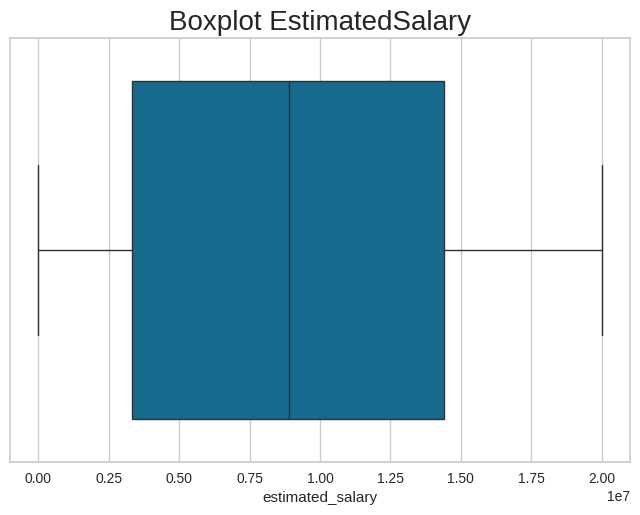

In [ ]:
plt.title("Boxplot EstimatedSalary", fontdict = {'fontsize': 20})
sns.boxplot(x=df["estimated_salary"])

* Nhìn vào các boxplots, có outliers ( ở balance, age, credit_score) => dùng Skew phân phối chuẩn và xóa outlier

### Bivariate variable

<Axes: title={'center': 'Variable Gender'}, xlabel='gender', ylabel='count'>

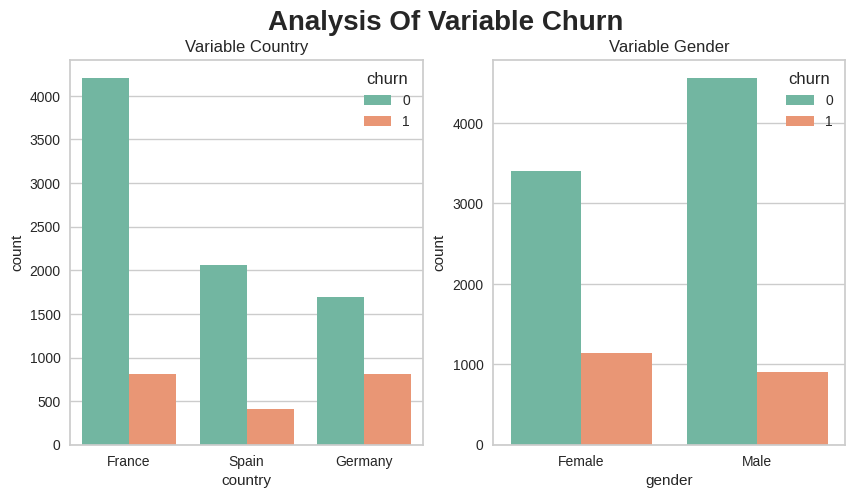

In [ ]:
plt.figure(figsize = (10,5))
plt.suptitle("Analysis Of Variable Churn",fontweight="bold", fontsize=20)

plt.subplot(1, 2, 1)
plt.gca().set_title('Variable Country')
sns.countplot(x = 'country', hue = 'churn', palette = 'Set2', data = df)

plt.subplot(1, 2, 2)
plt.gca().set_title('Variable Gender')
sns.countplot(x = 'gender', hue = 'churn', palette = 'Set2', data = df)

* Ta thấy rằng ở biến country và gender, churn and non-churn have the same behavior

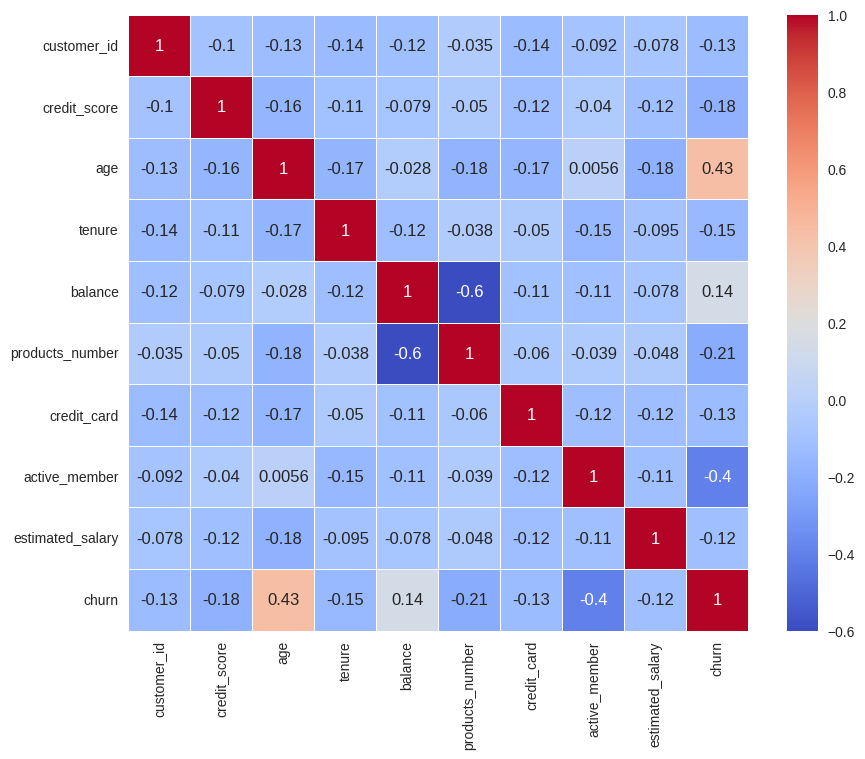

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
data = df[numeric_columns].corr()
plt.figure(figsize = (10,8))
sns.heatmap(data.corr(), annot = True, cmap = 'coolwarm', linewidths = 0.5)
plt.show()

* Ta thấy Age  có sự ảnh hưởng tương đối với Churn (positive)
* Trong khi Active_member có sự đối nghịch lớn so với Churn (negative)

# Handle Normal Distribution and drop outliers

In [ ]:
# Hàm xử lý outliers bằng phương pháp IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Số lượng outliers trong cột {column}: {len(outliers)}')

    df = df.drop(outliers.index)
    return df

In [ ]:
# Xử lý outliers cho các cột Age, Balance, và Credit_card
for col in ['age', 'balance', 'credit_card']:
    df = remove_outliers_iqr(df, col)
    print(f'DataFrame sau khi loại bỏ outliers:\n{df}')

Số lượng outliers trong cột age: 359
DataFrame sau khi loại bỏ outliers:
      customer_id  credit_score  country  gender  age  tenure     balance  \
0        15634602           619   France  Female   42       2         0.0   
1        15647311           608    Spain  Female   41       1   8380786.0   
2        15619304           502   France  Female   42       8   1596608.0   
3        15701354           699   France  Female   39       1         0.0   
4        15737888           850    Spain  Female   43       2  12551082.0   
...           ...           ...      ...     ...  ...     ...         ...   
9995     15606229           771   France    Male   39       5         0.0   
9996     15569892           516   France    Male   35      10   5736961.0   
9997     15584532           709   France  Female   36       7         0.0   
9998     15682355           772  Germany    Male   42       3   7507531.0   
9999     15628319           792   France  Female   28       4  13014279.0   

  

In [ ]:
print("Skewness before transformation:")
print(df[['age', 'balance', 'credit_score']].skew())

Skewness before transformation:
age             0.490409
balance         0.058759
credit_score   -0.072269
dtype: float64



Skewness after Log Transformation:
credit_score   -0.072269
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


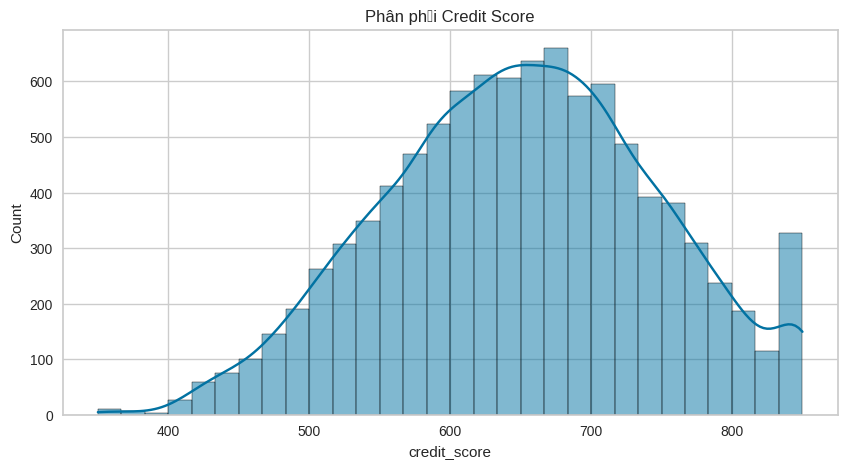

In [ ]:
# Áp dụng log transformation cho Credit_score
df['age'] = np.log1p(df['credit_score'])  # log1p để xử lý giá trị 0

# Kiểm tra độ lệch (skew) sau khi điều chỉnh
print("\nSkewness after Log Transformation:")
print(df[['credit_score']].skew())

# Vẽ biểu đồ phân phối
plt.figure(figsize=(10, 5))
sns.histplot(df['credit_score'], bins=30, kde=True)
plt.title('Phân phối Credit Score')
plt.show


Skewness after Log Transformation:
balance   -0.556366
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


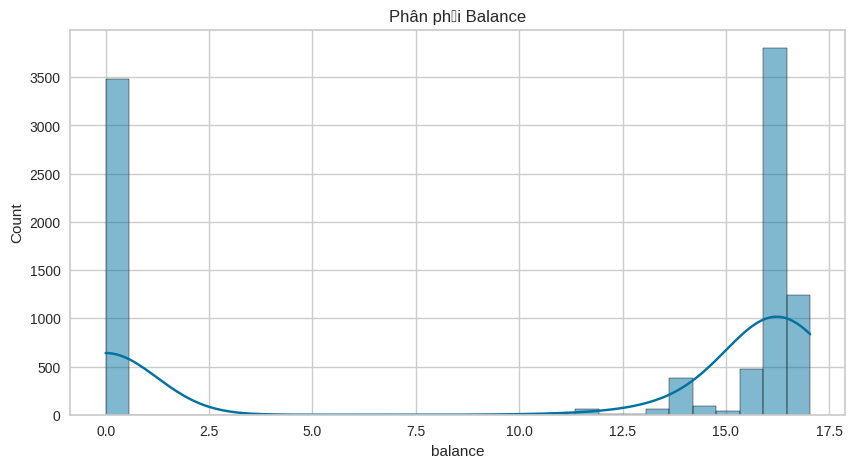

In [ ]:
# Áp dụng log transformation cho Balance
df['balance'] = np.log1p(df['balance'])  # log1p để xử lý giá trị 0

# Kiểm tra độ lệch (skew) sau khi điều chỉnh
print("\nSkewness after Log Transformation:")
print(df[['balance']].skew())

# Vẽ biểu đồ phân phối
plt.figure(figsize=(10, 5))
sns.histplot(df['balance'], bins=30, kde=True)
plt.title('Phân phối Balance')
plt.show

# Encoding categorical data

In [ ]:
# we will drop customer_ID variable that will not be used in the model
df = df.drop('customer_id', axis = 1)

In [ ]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,6.429719,2,0.000000,1,1,1,10134888.0,1
1,608,Spain,Female,6.411818,1,15.941452,1,0,1,11254258.0,0
2,502,France,Female,6.220590,8,14.283393,3,1,0,11393157.0,1
3,699,France,Female,6.551080,1,0.000000,2,0,0,9382663.0,0
4,850,Spain,Female,6.746412,2,16.345318,1,1,1,790841.0,0


#### Encode Country and Gender variable

In [ ]:
df['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [ ]:
# Cách 1: One-Hot bằng hàm get_dummies của pandas
df_country = pd.get_dummies(df['country'], dtype='int')
df_gender = pd.get_dummies(df['gender'], dtype='int')

df = pd.concat([df, df_country, df_gender], axis = 1)
df.drop(['country', 'gender'], axis = 1, inplace = True)

df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,France,Germany,Spain,Female,Male
0,619,6.429719,2,0.000000,1,1,1,10134888.0,1,1,0,0,1,0
1,608,6.411818,1,15.941452,1,0,1,11254258.0,0,0,0,1,1,0
2,502,6.220590,8,14.283393,3,1,0,11393157.0,1,1,0,0,1,0
3,699,6.551080,1,0.000000,2,0,0,9382663.0,0,1,0,0,1,0
4,850,6.746412,2,16.345318,1,1,1,790841.0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,6.648985,5,0.000000,2,1,0,9627064.0,0,1,0,0,0,1
9996,516,6.248043,10,15.562440,1,1,1,10169977.0,0,1,0,0,0,1
9997,709,6.565265,7,0.000000,1,0,1,4208558.0,1,1,0,0,1,0
9998,772,6.650279,3,15.831417,2,1,0,9288852.0,1,0,1,0,0,1


* Ta có hai cột country và gender đã được one-hot encode

# Split feature variables and target variable

In [ ]:
X = df.drop('churn', axis = 1)
y = df['churn'].values

In [ ]:
X,y

(      credit_score       age  tenure    balance  products_number  credit_card  \
 0              619  6.429719       2   0.000000                1            1   
 1              608  6.411818       1  15.941452                1            0   
 2              502  6.220590       8  14.283393                3            1   
 3              699  6.551080       1   0.000000                2            0   
 4              850  6.746412       2  16.345318                1            1   
 ...            ...       ...     ...        ...              ...          ...   
 9995           771  6.648985       5   0.000000                2            1   
 9996           516  6.248043      10  15.562440                1            1   
 9997           709  6.565265       7   0.000000                1            0   
 9998           772  6.650279       3  15.831417                2            1   
 9999           792  6.675823       4  16.381558                1            1   
 
       active_

# Transform data into Train/Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
print(X_test.shape)
print(X_train.shape)

(2893, 13)
(6748, 13)


In [ ]:
# summarize the new class distribution
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 5376, 1: 1372})
Counter({0: 2301, 1: 592})


# Handle Imbalanced data with SMOTE

In [ ]:
#oversampling dataset
oversample=SMOTE()
X_train_smote, y_train_smote=oversample.fit_resample(X_train,y_train)

#count y
Counter(y_train_smote)

Counter({0: 5376, 1: 5376})

# Scale data

In [ ]:
scaling=StandardScaler()
X_train_smote=scaling.fit_transform(X_train_smote)
X_test=scaling.fit_transform(X_test)

# Model Training

## So sánh và lựa chọn sử dụng những model sau:

* Logistic Regression
* Decision Tree
* Random Forest
* K Nearest Neighbors (KNN)
* Support Vector Machine (SVC)
* Boosting Models: AdaBoost, GradientBoosting, XGBoost, Light GBM

In [ ]:
from tqdm import tqdm
models={"Logistic Regression": LogisticRegression(),"Decision Tree Classifier": DecisionTreeClassifier(),"Random Forest": RandomForestClassifier(),"K Nearest Neighbors":KNeighborsClassifier(),"Support Vector Machine":SVC(),"AdaBoost": AdaBoostClassifier(),"Gradient Boosting": GradientBoostingClassifier(),"XGBoost": XGBClassifier(),"LightGBM": LGBMClassifier()}
for name, model in tqdm(models.items(), desc="Training models", total=len(models)):
  model.fit(X_train_smote, y_train_smote)
  score = model.score(X_test, y_test)
  model_pred = model.predict(X_test)
  print()
  tqdm.write(f"Model: {name} has an Accuracy of {score:.2%}")

Training models:  11%|█         | 1/9 [00:00<00:01,  7.90it/s]


Model: Logistic Regression has an Accuracy of 21.12%

Model: Decision Tree Classifier has an Accuracy of 51.85%


Training models:  33%|███▎      | 3/9 [00:03<00:08,  1.45s/it]


Model: Random Forest has an Accuracy of 63.15%


Training models:  44%|████▍     | 4/9 [00:04<00:06,  1.27s/it]


Model: K Nearest Neighbors has an Accuracy of 76.67%


Training models:  56%|█████▌    | 5/9 [00:09<00:11,  2.76s/it]


Model: Support Vector Machine has an Accuracy of 73.52%


Training models:  67%|██████▋   | 6/9 [00:10<00:06,  2.10s/it]


Model: AdaBoost has an Accuracy of 75.98%


Training models:  78%|███████▊  | 7/9 [00:12<00:04,  2.15s/it]


Model: Gradient Boosting has an Accuracy of 66.40%


Training models:  89%|████████▉ | 8/9 [00:13<00:01,  1.56s/it]


Model: XGBoost has an Accuracy of 20.46%
[LightGBM] [Info] Number of positive: 5376, number of negative: 5376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Training models: 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


Model: LightGBM has an Accuracy of 55.69%


In [ ]:
#Logistic Regression
Logis_model = LogisticRegression()
Logis_model.fit(X_train_smote, y_train_smote)

LogisticRegression()

In [ ]:
#Decision Tree
Decis_model = DecisionTreeClassifier()
Decis_model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [ ]:
#Random Forest
Random_model = RandomForestClassifier()
Random_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [ ]:
#Use hyperparameters
#Random Forest
Random1_model = RandomForestClassifier(criterion= 'gini', max_depth= None,n_estimators=30)
Random1_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=30)

In [ ]:
#K Nearest Neighbors
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier()

In [ ]:
#Use hyperparameters
#K Nearest Neighbors
KNN1_model = KNeighborsClassifier(n_neighbors=7)
KNN1_model.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
#SVC
SVC_model = SVC()
SVC_model.fit(X_train_smote, y_train_smote)

SVC()

In [ ]:
#Use hyperparameters
#SVC
SVC1_model = SVC(C=100  ,gamma=0.001)
SVC1_model.fit(X_train_smote, y_train_smote)

SVC(C=100, gamma=0.001)

In [ ]:
#AdaBoost
Ada_model = AdaBoostClassifier()
Ada_model.fit(X_train_smote, y_train_smote)

AdaBoostClassifier()

In [ ]:
#Use hyperparameters
#AdaBoost
Ada1_model = AdaBoostClassifier(learning_rate=1, n_estimators=200)
Ada1_model.fit(X_train_smote, y_train_smote)

AdaBoostClassifier(learning_rate=1, n_estimators=200)

In [ ]:
#Gradient Boosting
Gra_model = GradientBoostingClassifier()
Gra_model.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier()

In [ ]:
#Use hyperparameters
#Gradient Boosting
Gra1_model = GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', n_estimators= 150)
Gra1_model.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(loss='exponential', n_estimators=150)

In [ ]:
#XGBoost
XGB_model = XGBClassifier()
XGB_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#LightGBM
GBM_model = LGBMClassifier()
GBM_model.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 5376, number of negative: 5376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier()

In [ ]:
#Use hyperparameters
#LightGBM
GBM1_model = LGBMClassifier(learning_rate=0.1, n_estimators= 180)
GBM1_model.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 5376, number of negative: 5376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(n_estimators=180)

# Model evaluation

In [ ]:
#Logistic Regression
y_pred_logis = Logis_model.predict(X_test)
print(confusion_matrix(y_pred_logis, y_test))
print(classification_report(y_pred_logis, y_test))

[[  29   10]
 [2272  582]]
              precision    recall  f1-score   support

           0       0.01      0.74      0.02        39
           1       0.98      0.20      0.34      2854

    accuracy                           0.21      2893
   macro avg       0.50      0.47      0.18      2893
weighted avg       0.97      0.21      0.33      2893



In [ ]:
#Decision Tree
y_pred_decis = Decis_model.predict(X_test)
print(confusion_matrix(y_pred_decis, y_test))
print(classification_report(y_pred_decis, y_test))

[[1141  258]
 [1160  334]]
              precision    recall  f1-score   support

           0       0.50      0.82      0.62      1399
           1       0.56      0.22      0.32      1494

    accuracy                           0.51      2893
   macro avg       0.53      0.52      0.47      2893
weighted avg       0.53      0.51      0.46      2893



In [ ]:
#Random Forest
y_pred_random = Random_model.predict(X_test)
print(confusion_matrix(y_pred_random, y_test))
print(classification_report(y_pred_random, y_test))

[[1555  281]
 [ 746  311]]
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1836
           1       0.53      0.29      0.38      1057

    accuracy                           0.65      2893
   macro avg       0.60      0.57      0.56      2893
weighted avg       0.62      0.65      0.61      2893



In [ ]:
#Use hyperparameters
#Random Forest
y_pred_random1 = Random1_model.predict(X_test)
print(confusion_matrix(y_pred_random1, y_test))
print(classification_report(y_pred_random1, y_test))

[[1429  289]
 [ 872  303]]
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      1718
           1       0.51      0.26      0.34      1175

    accuracy                           0.60      2893
   macro avg       0.57      0.54      0.53      2893
weighted avg       0.58      0.60      0.56      2893



In [ ]:
#K Nearest Neighbors
y_pred_knn = KNN_model.predict(X_test)
print(confusion_matrix(y_pred_knn, y_test))
print(classification_report(y_pred_knn, y_test))

[[1996  370]
 [ 305  222]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      2366
           1       0.38      0.42      0.40       527

    accuracy                           0.77      2893
   macro avg       0.62      0.63      0.63      2893
weighted avg       0.78      0.77      0.77      2893



In [ ]:
#Use hyperparameters
#K Nearest Neighbors
y_pred_knn1 = KNN1_model.predict(X_test)
print(confusion_matrix(y_pred_knn1, y_test))
print(classification_report(y_pred_knn1, y_test))

[[2014  387]
 [ 287  205]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2401
           1       0.35      0.42      0.38       492

    accuracy                           0.77      2893
   macro avg       0.61      0.63      0.62      2893
weighted avg       0.79      0.77      0.78      2893



In [ ]:
#SVC
y_pred_svc = SVC_model.predict(X_test)
print(confusion_matrix(y_pred_svc, y_test))
print(classification_report(y_pred_svc, y_test))

[[1740  205]
 [ 561  387]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1945
           1       0.65      0.41      0.50       948

    accuracy                           0.74      2893
   macro avg       0.70      0.65      0.66      2893
weighted avg       0.72      0.74      0.72      2893



In [ ]:
#Use hyperparameters
#SVC
y_pred_svc1 = SVC1_model.predict(X_test)
print(confusion_matrix(y_pred_svc1, y_test))
print(classification_report(y_pred_svc1, y_test))

[[1215   88]
 [1086  504]]
              precision    recall  f1-score   support

           0       0.53      0.93      0.67      1303
           1       0.85      0.32      0.46      1590

    accuracy                           0.59      2893
   macro avg       0.69      0.62      0.57      2893
weighted avg       0.71      0.59      0.56      2893



In [ ]:
#AdaBoost
y_pred_ada = Ada_model.predict(X_test)
print(confusion_matrix(y_pred_ada, y_test))
print(classification_report(y_pred_ada, y_test))

[[1878  272]
 [ 423  320]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2150
           1       0.54      0.43      0.48       743

    accuracy                           0.76      2893
   macro avg       0.68      0.65      0.66      2893
weighted avg       0.75      0.76      0.75      2893



In [ ]:
#Use hyperparameters
#AdaBoost
y_pred_ada1 = Ada1_model.predict(X_test)
print(confusion_matrix(y_pred_ada1, y_test))
print(classification_report(y_pred_ada1, y_test))

[[1357  239]
 [ 944  353]]
              precision    recall  f1-score   support

           0       0.59      0.85      0.70      1596
           1       0.60      0.27      0.37      1297

    accuracy                           0.59      2893
   macro avg       0.59      0.56      0.54      2893
weighted avg       0.59      0.59      0.55      2893



In [ ]:
#Gradient Boosting
y_pred_gra = Gra_model.predict(X_test)
print(confusion_matrix(y_pred_gra, y_test))
print(classification_report(y_pred_gra, y_test))

[[1589  265]
 [ 712  327]]
              precision    recall  f1-score   support

           0       0.69      0.86      0.76      1854
           1       0.55      0.31      0.40      1039

    accuracy                           0.66      2893
   macro avg       0.62      0.59      0.58      2893
weighted avg       0.64      0.66      0.63      2893



In [ ]:
#Use hyperparameters
#Gradient Boosting
y_pred_gra1 = Gra1_model.predict(X_test)
print(confusion_matrix(y_pred_gra1, y_test))
print(classification_report(y_pred_gra1, y_test))

[[1352  269]
 [ 949  323]]
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      1621
           1       0.55      0.25      0.35      1272

    accuracy                           0.58      2893
   macro avg       0.57      0.54      0.52      2893
weighted avg       0.57      0.58      0.54      2893



In [ ]:
#XGBoost
y_pred_xbg = XGB_model.predict(X_test)
print(confusion_matrix(y_pred_xbg, y_test))
print(classification_report(y_pred_xbg, y_test))

[[   0    0]
 [2301  592]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.20      0.34      2893

    accuracy                           0.20      2893
   macro avg       0.50      0.10      0.17      2893
weighted avg       1.00      0.20      0.34      2893



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#LightGBM
y_pred_gbm = GBM_model.predict(X_test)
print(confusion_matrix(y_pred_gbm, y_test))
print(classification_report(y_pred_gbm, y_test))

[[1294  275]
 [1007  317]]
              precision    recall  f1-score   support

           0       0.56      0.82      0.67      1569
           1       0.54      0.24      0.33      1324

    accuracy                           0.56      2893
   macro avg       0.55      0.53      0.50      2893
weighted avg       0.55      0.56      0.51      2893



In [ ]:
#Use hyperparameters
#LightGBM
y_pred_gbm1 = GBM1_model.predict(X_test)
print(confusion_matrix(y_pred_gbm1, y_test))
print(classification_report(y_pred_gbm1, y_test))

[[1265  276]
 [1036  316]]
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      1541
           1       0.53      0.23      0.33      1352

    accuracy                           0.55      2893
   macro avg       0.54      0.53      0.49      2893
weighted avg       0.54      0.55      0.50      2893



# Model results

In [ ]:
models={"Logistic Regression": LogisticRegression(),"Decision Tree Classifier": DecisionTreeClassifier(),"Random Forest": RandomForestClassifier(),"Random Forest hyper":RandomForestClassifier(criterion= 'gini', max_depth= None,n_estimators=30),"K Nearest Neighbors":KNeighborsClassifier(),"K Nearest Neighbors hyper":KNeighborsClassifier(n_neighbors=7),"Support Vector Machine":SVC(),"Support Vector Machine hyper":SVC(C=100  ,gamma=0.001),"AdaBoost": AdaBoostClassifier(),"AdaBoost hyper":AdaBoostClassifier(learning_rate=1, n_estimators=200),"Gradient Boosting": GradientBoostingClassifier(),"Gradient Boosting hyper":GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', n_estimators= 150),"XGBoost": XGBClassifier(),"LightGBM": LGBMClassifier(),"LightGBM hyper":LGBMClassifier(learning_rate=0.1, n_estimators= 180)}
# Dictionary to store metrics
metrics_results = {'Model': [],
                   'Accuracy': [],
                   'Precision': [],
                   'Recall': [],
                   'F1-Score': [],
                   'Support': []
                  }

# Iterating over each model
for name, model in models.items():

    # Training the model
    model.fit(X_train_smote, y_train_smote)

    # Prediction on the test set
    y_pred = model.predict(X_test)

    # Calculating accuracy
    acc = accuracy_score(y_test, y_pred)

    # Calculating other metrics using classification_report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Storing accuracy and other metrics results in the dictionary
    metrics_results['Model'].append(name)
    metrics_results['Accuracy'].append(acc)
    metrics_results['Precision'].append(report['weighted avg']['precision'])
    metrics_results['Recall'].append(report['weighted avg']['recall'])
    metrics_results['F1-Score'].append(report['weighted avg']['f1-score'])
    metrics_results['Support'].append(report['weighted avg']['support'])

# Creating DataFrame with the results
df_metrics = pd.DataFrame(metrics_results)

# Displaying the DataFrame sorted by the accuracy column in descending order
df_metrics_sorted = df_metrics.sort_values(by='Accuracy', ascending=False)
df_metrics_sorted.head()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Info] Number of positive: 5376, number of negative: 5376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5376, number of negative: 5376
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.00000

,Model,Accuracy,Precision,Recall,F1-Score,Support
5,K Nearest Neighbors hyper,0.767024,0.752432,0.767024,0.758755,2893.0
4,K Nearest Neighbors,0.766678,0.757188,0.766678,0.761526,2893.0
8,AdaBoost,0.759765,0.782877,0.759765,0.769276,2893.0
6,Support Vector Machine,0.735223,0.795074,0.735223,0.754727,2893.0
3,Random Forest hyper,0.673004,0.738843,0.673004,0.697091,2893.0


* Có thể sử dụng các mô hình AdaBoost, KNN hoặc SVC do accuracy cao nhất, trên 70%

In [ ]:
#K Nearest Neighbors
# Grid Search
knn = KNeighborsClassifier()
grid_space = {'n_neighbors':[2, 3, 4, 5, 6, 7, 8]}
KNN_grid = GridSearchCV(knn, param_grid=grid_space, scoring='accuracy')
KNN_model_grid = KNN_grid.fit(X_train_smote, y_train_smote)
# print best parameter after tuning
print(KNN_grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(KNN_grid.best_estimator_)

{'n_neighbors': 4}
KNeighborsClassifier(n_neighbors=4)


In [ ]:
#Random Forest
# Grid Search
rf = RandomForestClassifier()
grid_space = {'max_depth':[3, 5, 10, None],
              'n_estimators':[10, 20, 30],
              'criterion':['gini','entropy']
              }
rf_grid = GridSearchCV(rf, param_grid=grid_space, scoring='accuracy')
model_grid = rf_grid.fit(X_train_smote, y_train_smote)
# Best hyperparameters
print('Best hyperparameters: '+str(model_grid.best_params_))
print('Best score: '+str(model_grid.best_score_))

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 20}
Best score: 0.8512122647119241


In [ ]:
#SVC
model = SVC()
param_grid = {'C':[1,10,100],'gamma':[1,0.1,0.001]}
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
SVC_model_grid = grid.fit(X_train_smote, y_train_smote)

# print best parameter after tuning
print(grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .......................................C=1, gamma=1; total time=   6.7s
[CV] END .......................................C=1, gamma=1; total time=   7.6s
[CV] END .......................................C=1, gamma=1; total time=   5.7s
[CV] END .......................................C=1, gamma=1; total time=   5.9s
[CV] END .......................................C=1, gamma=1; total time=   5.8s
[CV] END .....................................C=1, gamma=0.1; total time=   1.4s
[CV] END .....................................C=1, gamma=0.1; total time=   2.2s
[CV] END .....................................C=1, gamma=0.1; total time=   2.4s
[CV] END .....................................C=1, gamma=0.1; total time=   3.9s
[CV] END .....................................C=1, gamma=0.1; total time=   2.4s
[CV] END ...................................C=1, gamma=0.001; total time=   2.2s
[CV] END ...................................C=1, 

In [ ]:
#AdaBoost
# Grid Search
ada=ada=AdaBoostClassifier()
parameters = {
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(ada, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_train_smote, y_train_smote)
# print best parameter after tuning
print(grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'learning_rate': 1, 'n_estimators': 200}


In [ ]:
#Gradient Boosting
# Grid Search
gb = GradientBoostingClassifier()

parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}

grid_search = GridSearchCV(gb, parameters, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train_smote, y_train_smote)
# print best parameter after tuning
print(grid_search.best_params_)

In [ ]:
#LightGBM
# Grid Search
lb = LGBMClassifier()
parameters = {
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(lb, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_train_smote, y_train_smote)
# print best parameter after tuning
print(grid_search.best_params_)

The model KNN does not support feature importance extraction.
The model Support Vector Machine does not support feature importance extraction.


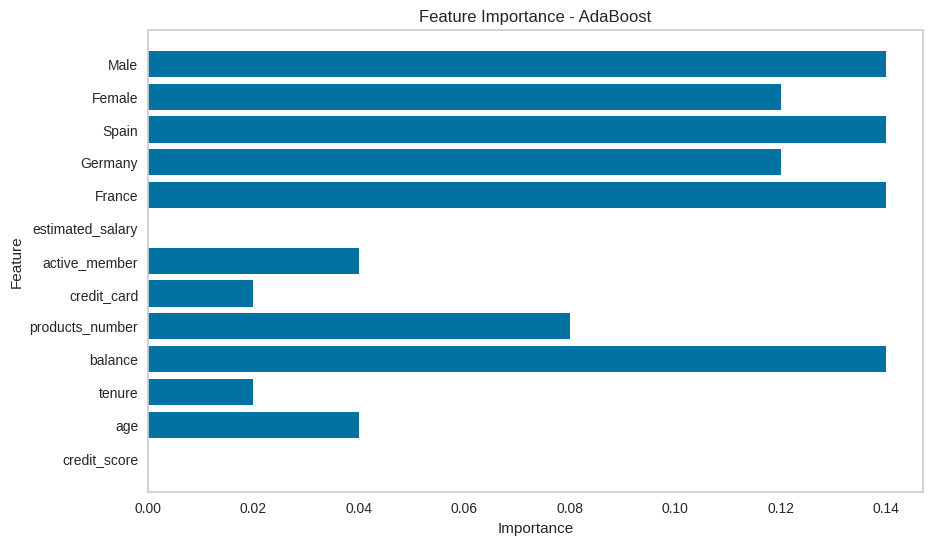

In [76]:
models={"KNN": KNeighborsClassifier(),"Support Vector Machine":SVC(),"AdaBoost": AdaBoostClassifier()}
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances = model.coef_[0]
    else:
        feature_importances = None

    if feature_importances is not None:
        # Plotting feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importances)), feature_importances)
        plt.title(f"Feature Importance - {model_name}")
        plt.ylabel("Feature")
        plt.xlabel("Importance")
        plt.grid(False)
        plt.yticks(range(len(feature_importances)),X_train.columns) # Assuming X_train is a pandas DataFrame
        plt.show()
    else:
        print(f"The model {model_name} does not support feature importance extraction.")

Mô hình AdaBoost chỉ ra rằng Balance ảnh hưởng mạnh đến quyết định rời bỏ của khách hàng, tiếp đến là country và gender